In [388]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [389]:
BASE_URL = "https://data.cdc.gov/resource/r8kw-7aab.json"
LIMIT = 50000
offset = 0
all_data = []

while True:
   params = {
       "$limit": LIMIT,
       "$offset": offset
   }
   response = requests.get(BASE_URL, params=params)
   data = response.json()
   if not data:
       break
   all_data.extend(data)
   offset += LIMIT
   
df = pd.DataFrame(all_data)


In [390]:
print(df.duplicated().sum())
df = df.drop_duplicates()
df.info()

0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18954 entries, 0 to 18953
Data columns (total 17 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   data_as_of                              18954 non-null  object
 1   start_date                              18954 non-null  object
 2   end_date                                18954 non-null  object
 3   group                                   18954 non-null  object
 4   year                                    18900 non-null  object
 5   mmwr_week                               15066 non-null  object
 6   week_ending_date                        15066 non-null  object
 7   state                                   18954 non-null  object
 8   covid_19_deaths                         15092 non-null  object
 9   total_deaths                            18950 non-null  object
 10  percent_of_expected_deaths              18900 non-null  object
 11  

In [391]:
df['year'] = df['year'].astype(str).str.extract(r'(\d{4})')
df['state'] = df['state'].replace('New York City', 'New York')

df.year.value_counts()

year
2020    3510
2021    3510
2022    3510
2023    3510
2024    3510
2025    1296
2019      54
Name: count, dtype: int64

In [392]:
# change data types
for col in ['data_as_of', 'start_date', 'end_date', 'week_ending_date']:
   df[col] = pd.to_datetime(df[col])
  
num_col = ['mmwr_week','covid_19_deaths','total_deaths','percent_of_expected_deaths','pneumonia_deaths','pneumonia_and_covid_19_deaths','influenza_deaths','pneumonia_influenza_or_covid_19_deaths','month']
df[num_col] = df[num_col].apply(pd.to_numeric, errors='coerce')

In [393]:
df['group'].value_counts()

group
By Week     15066
By Month     3510
By Year       324
By Total       54
Name: count, dtype: int64

In [394]:
weekly_df = df[df['group'] == 'By Week']
monthly_df = df[df['group'] == 'By Month']
annual_df = df[df['group'] == 'By Year']
total_df = df[df['group'] == 'By Total']

In [395]:
num_col = weekly_df.select_dtypes(include='number').columns


for col in num_col:
   mask = weekly_df[col].isna()
   if mask.any():
       # fill each NaN with a random int in [1,9]
       weekly_df.loc[mask, col] = np.random.randint(1, 10, size=mask.sum())
      
weekly_df = weekly_df.drop(columns=['footnote','month'])

In [396]:
weekly_df['%_covid'] = (weekly_df['covid_19_deaths'] / weekly_df['total_deaths']) * 100
weekly_df['%_covid+pneumonia'] = (weekly_df['pneumonia_and_covid_19_deaths'] / weekly_df['total_deaths'] )*100
weekly_df['%_covid|pneumonia'] = (weekly_df['pneumonia_influenza_or_covid_19_deaths'] / weekly_df['total_deaths'])*100

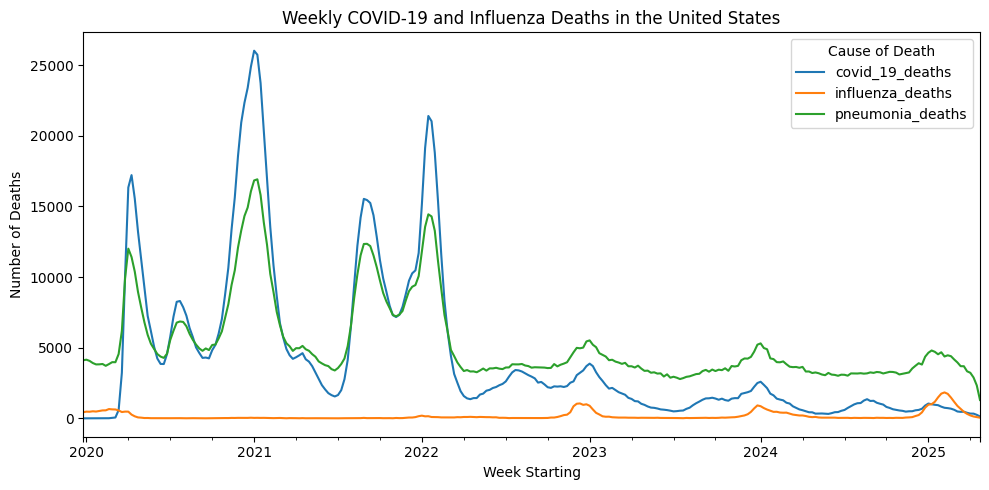

In [397]:
us_df = weekly_df[weekly_df['state'] == 'United States']


us_df.plot(
   kind='line',
   x='start_date',
   y=['covid_19_deaths', 'influenza_deaths','pneumonia_deaths'],
   figsize=(10, 5)
)


plt.xlabel('Week Starting')
plt.ylabel('Number of Deaths')
plt.title('Weekly COVID-19 and Influenza Deaths in the United States')
plt.legend(title='Cause of Death')
plt.tight_layout()
plt.show()


In [415]:
states_df = weekly_df[weekly_df['state'] != 'United States']
states_covid_weekly = states_df.groupby('state')['covid_19_deaths'].sum()
states_covid_weekly_sorted = states_covid_weekly.sort_values(ascending=False)

In [412]:
top_3_states = states_covid_weekly_sorted.index[:3]
bottom_3_states = states_covid_weekly_sorted.index[-3:]

In [417]:
states_covid_weekly_sorted[top_3_states]

state
California    116351.0
Texas         109102.0
Florida        87424.0
Name: covid_19_deaths, dtype: float64

In [418]:
states_covid_weekly_sorted[bottom_3_states]

state
Wyoming    2308.0
Alaska     1962.0
Vermont    1441.0
Name: covid_19_deaths, dtype: float64

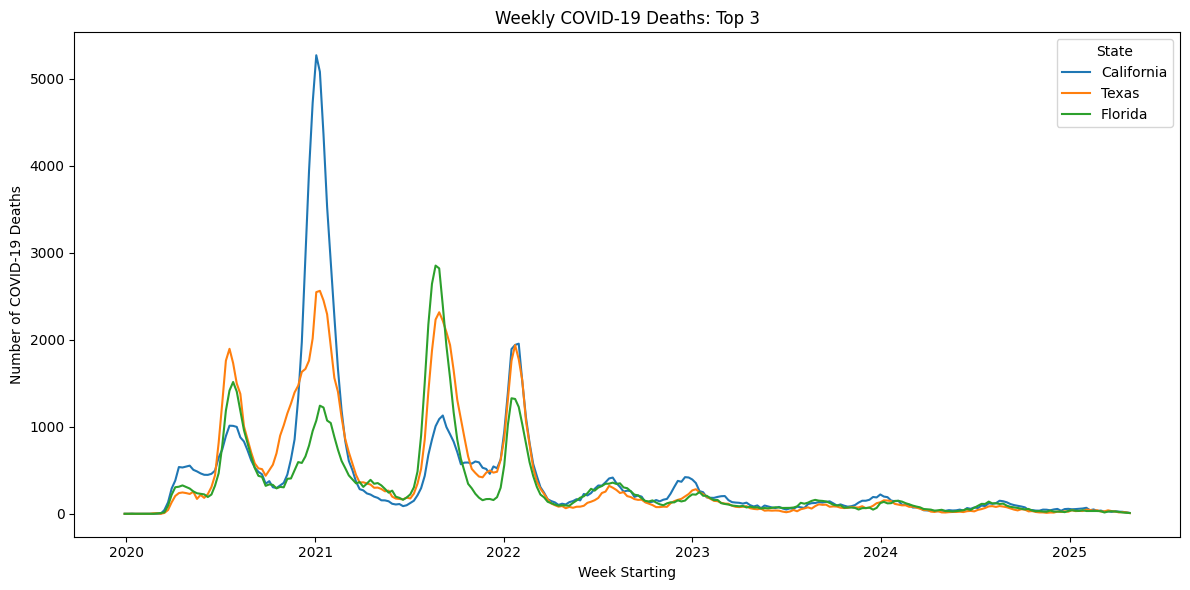

In [402]:
plt.figure(figsize=(12, 6))
for state in top_3_states:
    state_df = weekly_df[weekly_df['state'] == state]
    plt.plot(
        state_df['start_date'],
        state_df['covid_19_deaths'],
        label=state
    )

plt.xlabel('Week Starting')
plt.ylabel('Number of COVID-19 Deaths')
plt.title('Weekly COVID-19 Deaths: Top 3')
plt.legend(title='State')
plt.tight_layout()
plt.show()

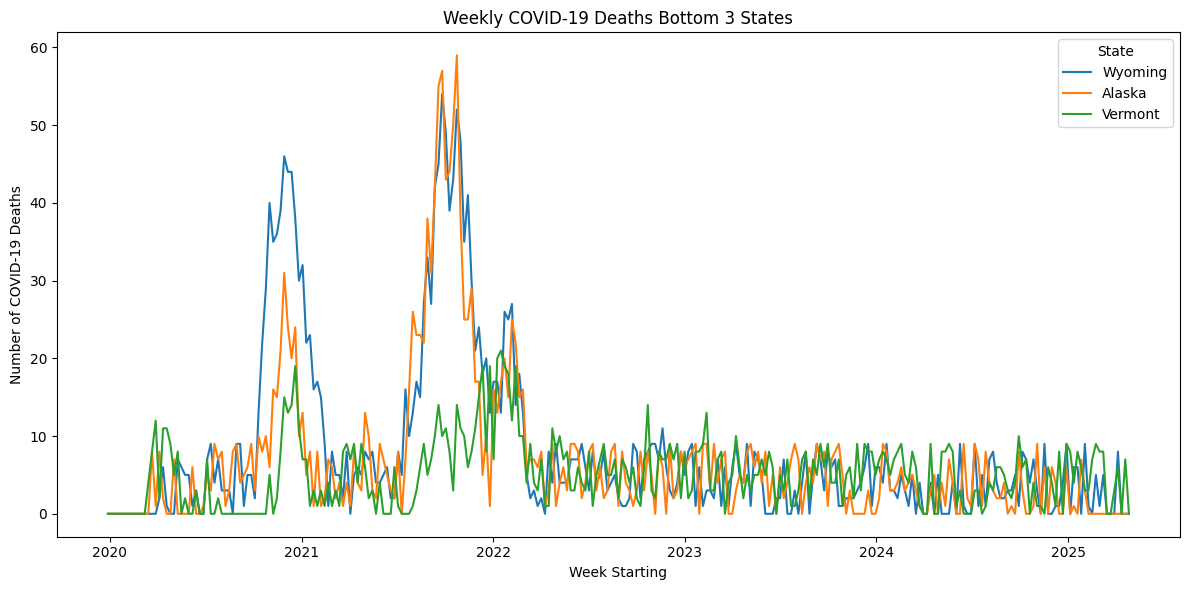

In [403]:
plt.figure(figsize=(12, 6))
for state in bottom_3_states:
    state_df = weekly_df[weekly_df['state'] == state]
    plt.plot(
        state_df['start_date'],
        state_df['covid_19_deaths'],
        label=state
    )

plt.xlabel('Week Starting')
plt.ylabel('Number of COVID-19 Deaths')
plt.title('Weekly COVID-19 Deaths Bottom 3 States')
plt.legend(title='State')
plt.tight_layout()
plt.show()

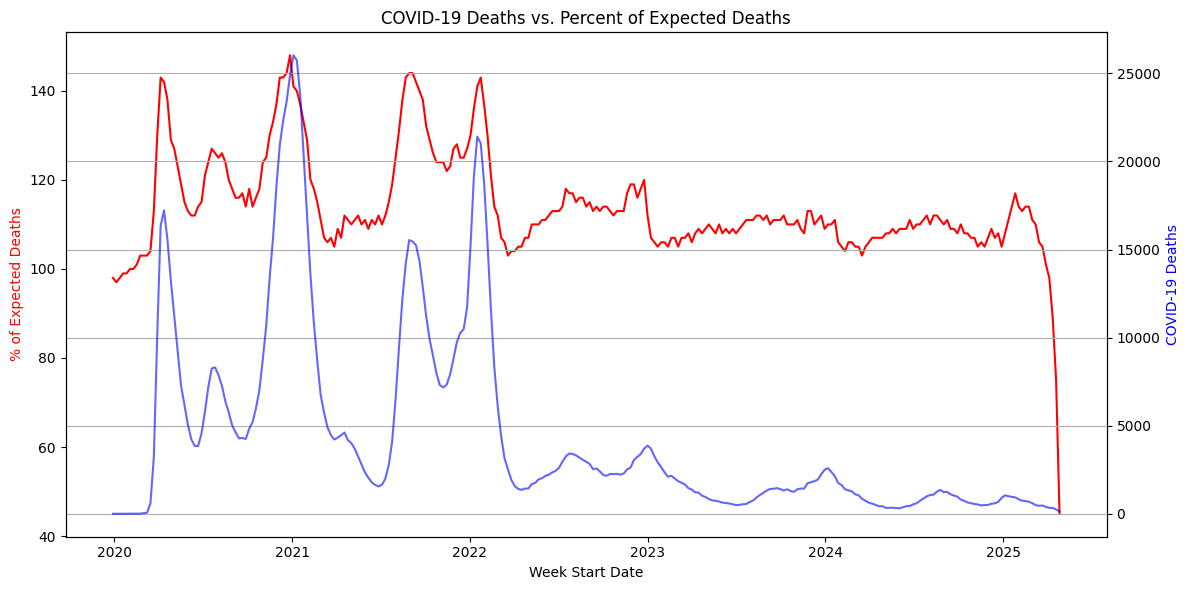

In [404]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Left Y-axis: Percent of Expected Deaths
ax1.plot(us_df['start_date'], us_df['percent_of_expected_deaths'], color='red', label='% of Expected Deaths')
ax1.set_xlabel('Week Start Date')
ax1.set_ylabel('% of Expected Deaths', color='red')
ax1.tick_params(axis='y')

# Right Y-axis: COVID-19 Deaths
ax2 = ax1.twinx()
ax2.plot(us_df['start_date'], us_df['covid_19_deaths'], color='blue', label='COVID-19 Deaths', alpha=0.6)
ax2.set_ylabel('COVID-19 Deaths', color='blue')
ax2.tick_params(axis='y',)

plt.title('COVID-19 Deaths vs. Percent of Expected Deaths')
fig.tight_layout()
plt.grid(True)
plt.show()


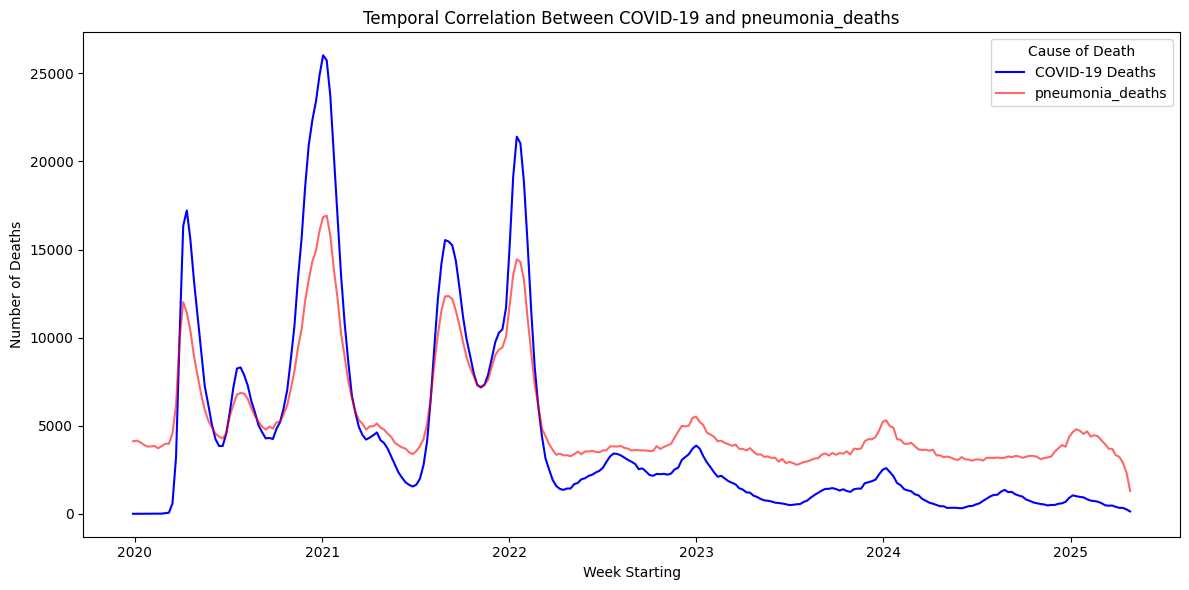

Pearson correlation coefficient between COVID-19 and pneumonia_deaths: 0.982


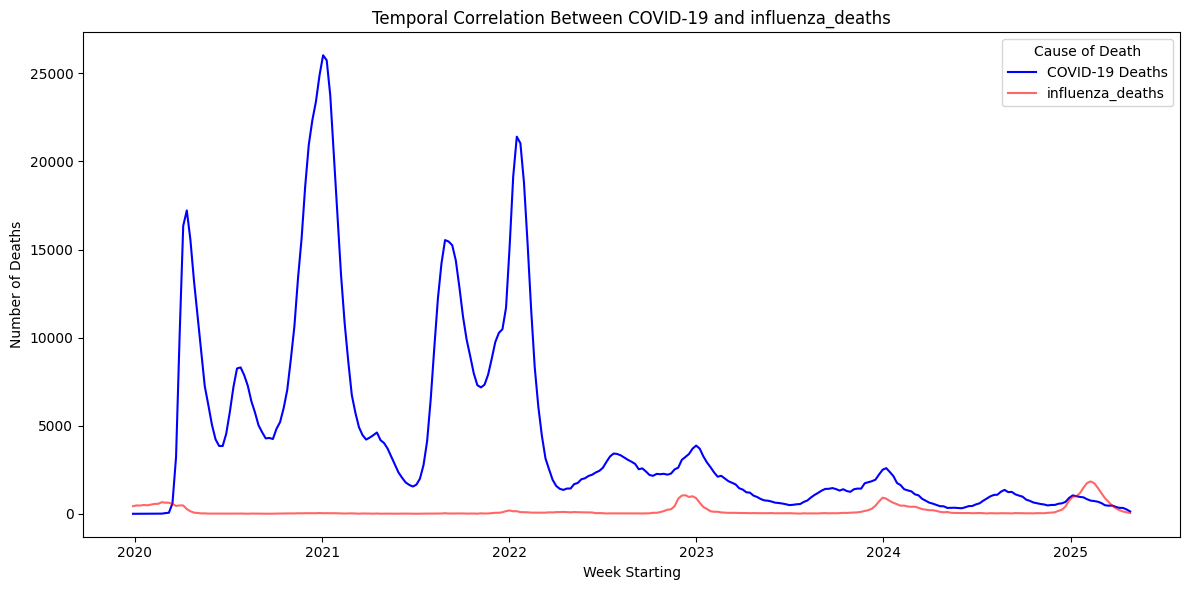

Pearson correlation coefficient between COVID-19 and influenza_deaths: -0.208


In [411]:
for x in ['pneumonia_deaths','influenza_deaths']:
    plt.figure(figsize=(12, 6))
    plt.plot(us_df['start_date'], us_df['covid_19_deaths'], label='COVID-19 Deaths', color='blue')
    plt.plot(us_df['start_date'], us_df[x], label=x , color='red', alpha=0.6)
    plt.xlabel('Week Starting')
    plt.ylabel('Number of Deaths')
    plt.title(f'Temporal Correlation Between COVID-19 and {x}')
    plt.legend(title='Cause of Death')
    plt.tight_layout()
    plt.show()

    # Calculate Pearson correlation coefficient
    correlation = us_df['covid_19_deaths'].corr(us_df[x])
    print(f'Pearson correlation coefficient between COVID-19 and {x}: {correlation:.3f}')

In [421]:
us_df.head()

,data_as_of,start_date,end_date,group,year,mmwr_week,week_ending_date,state,covid_19_deaths,total_deaths,percent_of_expected_deaths,pneumonia_deaths,pneumonia_and_covid_19_deaths,influenza_deaths,pneumonia_influenza_or_covid_19_deaths,%_covid,%_covid+pneumonia,%_covid|pneumonia
0,2025-05-08,2019-12-29,2020-01-04,By Week,2019,1.0,2020-01-04,United States,0.0,60170.0,98.0,4111.0,0.0,434.0,4545.0,0.000000,0.000000,7.553598
1,2025-05-08,2020-01-05,2020-01-11,By Week,2020,2.0,2020-01-11,United States,1.0,60734.0,97.0,4153.0,1.0,475.0,4628.0,0.001647,0.001647,7.620114
2,2025-05-08,2020-01-12,2020-01-18,By Week,2020,3.0,2020-01-18,United States,2.0,59362.0,98.0,4066.0,2.0,468.0,4534.0,0.003369,0.003369,7.637883
3,2025-05-08,2020-01-19,2020-01-25,By Week,2020,4.0,2020-01-25,United States,3.0,59162.0,99.0,3915.0,0.0,500.0,4418.0,0.005071,0.000000,7.467631
4,2025-05-08,2020-01-26,2020-02-01,By Week,2020,5.0,2020-02-01,United States,0.0,58834.0,99.0,3818.0,0.0,481.0,4299.0,0.000000,0.000000,7.306999


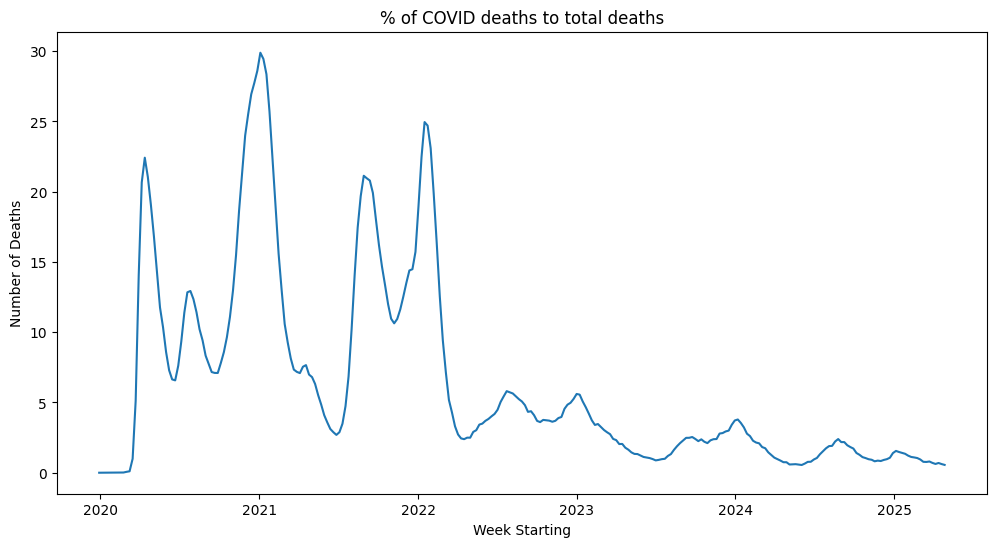

In [436]:
plt.figure(figsize=(12, 6))
plt.plot(us_df['start_date'], us_df['%_covid'])  # directly use plt.plot
plt.xlabel('Week Starting')
plt.ylabel('Number of Deaths')
plt.title('% of COVID deaths to total deaths')
plt.show()

### combined population dataset and check % of covid death by state's population

In [406]:
population = pd.read_csv('State_Population_2019-2025.csv')

In [407]:
# Rename the column 'Unnamed: 0' to 'State'
population.rename(columns={'Unnamed: 0': 'State'}, inplace=True)

pop_long = population.melt(id_vars='State', 
                           var_name='year', 
                           value_name='population')

pop_long['year'] = pop_long['year'].astype(int)
states_df['year'] = states_df['year'].astype(int)

merged_df = states_df.merge(pop_long, 
                            left_on=['state', 'year'], 
                            right_on=['State', 'year'], 
                            how='left')

merged_df.drop(columns='State', inplace=True)


/var/folders/59/04rfykkd6m96gklk1909pqyh0000gn/T/ipykernel_45237/1622344769.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_df['year'] = states_df['year'].astype(int)


In [408]:
merged_df['%_covid_per_pop'] = (merged_df['covid_19_deaths'] / merged_df['population']) * 100

### highest % of covid deaths 

In [409]:
merged_df.groupby(['state','year'])['%_covid_per_pop'].mean().sort_values(ascending=False).head()

state          year
West Virginia  2021    0.004198
Mississippi    2021    0.003800
New Jersey     2020    0.003798
South Dakota   2020    0.003791
North Dakota   2020    0.003747
Name: %_covid_per_pop, dtype: float64

In [419]:
merged_df.groupby('state',)['%_covid_per_pop'].mean().sort_values(ascending=False).head()

state
Mississippi      0.001954
West Virginia    0.001821
Kentucky         0.001791
Oklahoma         0.001789
Tennessee        0.001679
Name: %_covid_per_pop, dtype: float64